<a href="https://colab.research.google.com/github/myczu/AI/blob/main/MachineLearning5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sectors assigned to cats: {0: {'field_mouse': [(4.513736051478134, 33.33547984966721), (7.012284375931966, 4.154525284849331), (14.629943342150058, 19.375271664007727), (4.281916963553312, 24.477019023628294), (10.821386597171994, 8.996440608154128), (0.4058009871924617, 43.50671428382798), (12.9739014576431, 14.14068274497733), (6.162192717094533, 1.5206612676659015), (1.2468322130976761, 40.25036520640208), (0.9175411043612747, 26.930160741897403), (13.271630747332857, 27.74805934103644), (13.845626599899008, 11.566896177820068), (5.3487907920456825, 13.544044404594203), (11.513585716423275, 23.86812701583818), (15.105619989885216, 4.1876431845870865), (13.484254645017547, 31.346462069469965), (5.449912061558742, 48.53936065641578), (7.79529969786264, 41.18876649112748), (8.04747957349029, 3.91176531191898), (0.0991835286742071, 28.85916471607389), (12.267807422801575, 17.55682658779284), (11.652655298167808, 39.009687359471386), (11.010475918270817, 33.3281007190816), (7.34540164493

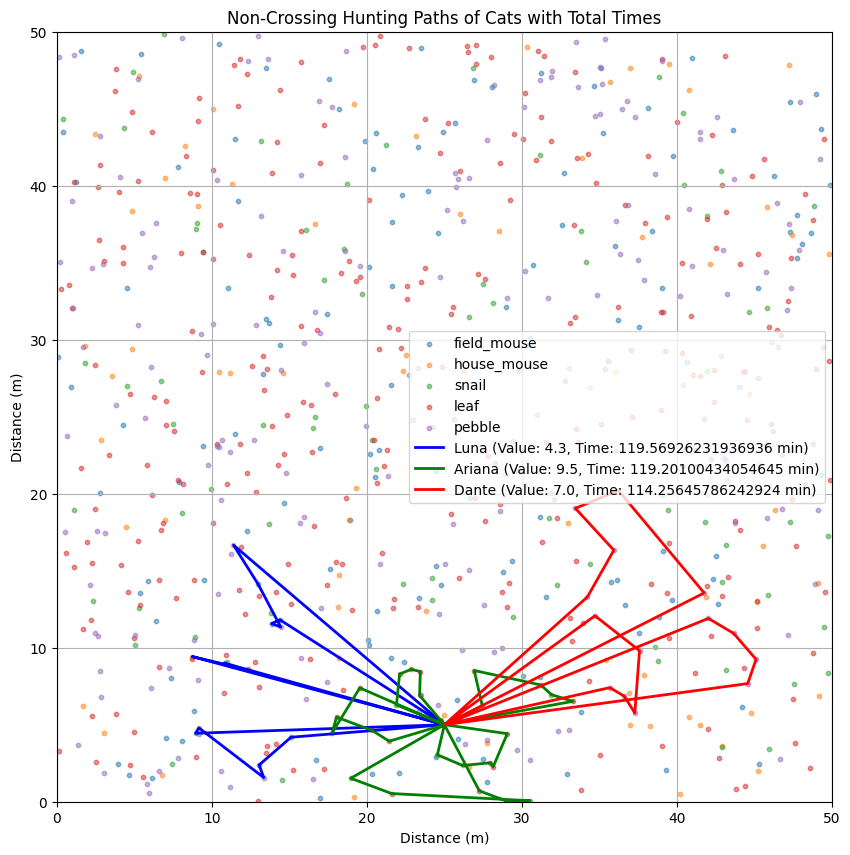

In [ ]:
import random
import matplotlib.pyplot as plt

# Stałe
AREA_SIZE = 2500  # w metrach kwadratowych
HUNTING_TIME_LIMIT = 2 * 60  # 2 godziny w minutach
CAT_CAPACITY = 5  # Maksymalna liczba przedmiotów, które kot może nieść
MOVEMENT_TIME_PER_CM = 0.01  # 10 cm/s w minutach

# Czas potrzebny do polowania na każdy przedmiot (w minutach)
HUNT_TIMES = {
    'field_mouse': 3,
    'house_mouse': 2,
    'snail': 1.5,
    'leaf': 1,
    'pebble': 0.5
}

# Liczba przedmiotów na terenie łowieckim
ITEM_COUNTS = {
    'field_mouse': 150,
    'house_mouse': 80,
    'snail': 90,
    'leaf': 300,
    'pebble': 200
}

# Preferencje kotów
PREFERENCES = {
    'Luna': {'field_mouse': 0.4, 'house_mouse': 0.4, 'snail': 0.1, 'pebble': 0.1, 'leaf': 0.0},
    'Ariana': {'snail': 0.375, 'leaf': 0.375, 'house_mouse': 0.125, 'field_mouse': 0.125, 'pebble': 0.0},
    'Dante': {'pebble': 0.5, 'house_mouse': 0.2, 'field_mouse': 0.2, 'snail': 0.05, 'leaf': 0.05}
}

# Inicjalizacja terenu łowieckiego z przedmiotami
def initialize_hunting_ground():
    hunting_ground = {}
    for item, count in ITEM_COUNTS.items():
        hunting_ground[item] = [random_position() for _ in range(count)]
    return hunting_ground

# Generowanie losowej pozycji w obrębie terenu łowieckiego
def random_position():
    return (random.uniform(0, AREA_SIZE ** 0.5), random.uniform(0, AREA_SIZE ** 0.5))

# Obliczanie czasu potrzebnego na przemieszczenie się z jednego miejsca na drugie
def movement_time(start, end):
    distance = ((start[0] - end[0]) ** 2 + (start[1] - end[1]) ** 2) ** 0.5
    return distance * 100 * MOVEMENT_TIME_PER_CM  # przekształcenie metrów na centymetry

# Obliczanie wartości przedmiotu na podstawie preferencji kota
def calculate_item_value(cat_name, item):
    return PREFERENCES[cat_name].get(item, 0)

# Podział terenu łowieckiego na sektory dla każdego kota
def divide_hunting_ground(hunting_ground, num_cats):
    sector_size = AREA_SIZE ** 0.5 / num_cats
    sectors = {}
    for i in range(num_cats):
        sectors[i] = {item: [] for item in hunting_ground.keys()}
    for item, positions in hunting_ground.items():
        for pos in positions:
            sector_index = int(pos[0] // sector_size)
            sectors[sector_index][item].append(pos)
    print(f"Sectors assigned to cats: {sectors}")
    return sectors

# Planowanie trasy polowania dla kota z powrotem do domu
def plan_hunting_route_with_home_return(cat_name, sectors, home_position, time_limit, capacity, sector):
    local_hunting_ground = sectors[sector].copy()
    current_position = home_position
    total_time = 0
    route = []
    items_collected = 0

    while total_time < time_limit and any(local_hunting_ground.values()):
        print(f"Current position: {current_position}, Items collected: {items_collected}")

        if items_collected == capacity:
            print("Returning home...")
            return_to_home_time = movement_time(current_position, home_position)
            if total_time + return_to_home_time > time_limit:
                print("Returning home would exceed time limit. Ending simulation.")
                break

            total_time += return_to_home_time
            route.append(('return_home', home_position))  # Dodanie punktu powrotu do trasy
            current_position = home_position
            items_collected = 0
            print("Returned home successfully.")
            continue

        best_item, best_position, best_score = None, None, -1
        for item, positions in local_hunting_ground.items():
            for pos in positions:
                travel_time_to_item = movement_time(current_position, pos) + HUNT_TIMES[item]
                travel_time_home = movement_time(pos, home_position)
                total_travel_time = travel_time_to_item + (travel_time_home if items_collected == capacity - 1 else 0)

                if total_time + total_travel_time > time_limit:
                    continue  # Pomijanie, jeśli łączny czas przekracza limit

                item_value = calculate_item_value(cat_name, item)
                score = item_value / total_travel_time  # wartość na jednostkę czasu

                if score > best_score:
                    best_score = score
                    best_item = item
                    best_position = pos

        if best_item is None:
            break

        route.append((best_item, best_position))
        total_time += movement_time(current_position, best_position) + HUNT_TIMES[best_item]
        current_position = best_position
        items_collected += 1

        local_hunting_ground[best_item].remove(best_position)

    print(f"Final route: {route}")
    return route, total_time


# Obliczanie łącznej wartości zdobyczy dla trasy
def calculate_total_value(route, cat_name):
    return sum(calculate_item_value(cat_name, item) for item, _ in route)

# Planowanie i ocena tras dla każdego kota w jego unikalnym sektorze
def plan_and_evaluate_unique_sector_routes(sectors, home_position, time_limit, capacity):
    routes = {}
    times = {}
    values = {}

    for i, cat_name in enumerate(PREFERENCES.keys()):
        print(f"Cat {cat_name} is using sector {i}")
        route, time = plan_hunting_route_with_home_return(cat_name, sectors, home_position, time_limit, capacity, i)
        value = calculate_total_value(route, cat_name)
        routes[cat_name] = route
        times[cat_name] = time
        values[cat_name] = value

    return routes, times, values

# Wizualizacja tras polowania kotów z uwzględnieniem czasu
def plot_hunting_paths_with_times(hunting_ground, routes, values, times, home_position):
    plt.figure(figsize=(10, 10))
    area_side_length = AREA_SIZE ** 0.5
    plt.xlim(0, area_side_length)
    plt.ylim(0, area_side_length)
    plt.title("Non-Crossing Hunting Paths of Cats with Total Times")
    plt.xlabel("Distance (m)")
    plt.ylabel("Distance (m)")

    # Wyświetlanie każdego przedmiotu na terenie łowieckim
    for item, positions in hunting_ground.items():
        x_vals = [pos[0] for pos in positions]
        y_vals = [pos[1] for pos in positions]
        plt.scatter(x_vals, y_vals, label=item, alpha=0.5, s=10)

    # Wyświetlanie ścieżki każdego kota
    cat_colors = {'Luna': 'blue', 'Ariana': 'green', 'Dante': 'red'}
    for cat_name, route in routes.items():
        path_x = [home_position[0]] + [pos[1][0] for pos in route] + [home_position[0]]
        path_y = [home_position[1]] + [pos[1][1] for pos in route] + [home_position[1]]
        plt.plot(path_x, path_y, label=f"{cat_name} (Value: {values[cat_name]}, Time: {times[cat_name]} min)", color=cat_colors[cat_name], linewidth=2)

    plt.legend()
    plt.grid(True)
    plt.show()

# Uruchomienie symulacji z unikalnymi sektorami dla każdego kota
def run_simulation_with_unique_sectors():
    hunting_ground = initialize_hunting_ground()
    home_position = (25, 5)  # Ustawienie domu w centrum
    sectors = divide_hunting_ground(hunting_ground, len(PREFERENCES))

    all_cat_unique_sector_routes, all_cat_unique_sector_times, all_cat_unique_sector_values = plan_and_evaluate_unique_sector_routes(sectors, home_position, HUNTING_TIME_LIMIT, CAT_CAPACITY)
    plot_hunting_paths_with_times(hunting_ground, all_cat_unique_sector_routes, all_cat_unique_sector_values, all_cat_unique_sector_times, home_position)

# Uruchomienie symulacji
run_simulation_with_unique_sectors()
